In [0]:
import pandas as pd
import numpy as np
from pprint import pprint

In [25]:
#import the dataset
dataset = pd.read_csv("zoo.csv",names=['animal_name','hair','feathers','eggs',
                                      'milk','airborne','aquatic','predator','toothed',
                                       'backbone','breathes','venomous',
                                       'fins','legs','tail',
                                       'domestic','catsize','class_type'])
#we drop this feature,since this is not good feature to split the data
dataset = dataset.drop('animal_name',axis=1)

###defining entropy
def entropy(target_col):
    elements,counts = np.unique(target_col,return_counts=True)
    entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy
  
##Info Gain

def InfoGain(data,split_attribute_name,target_name="class_type"):
    total_entropy = entropy(data[target_name])
    vals,counts = np.unique(data[split_attribute_name],return_counts=True)
    #cal the weighted entropy
    Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*entropy(data.where(data[split_attribute_name]==vals[i]).
                                dropna()[target_name])for i in range(len(vals))])
    
    #formula for information gain
    Information_Gain = total_entropy-Weighted_Entropy
    return Information_Gain

def ID3(data,originaldata,features,target_attribute_name="class_type",
        parent_node_class=None):
    #If all target_values have the same value,return this value
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]
    
    #if the dataset is empty
    elif len(data) == 0:
        return np.unique(originaldata[target_attribute_name])[np.argmax(np.unique(originaldata[target_attribute_name],
                                                                           return_counts=True)[1])]
    
    #If the feature space is empty
    elif len(features) == 0:
        return parent_node_class 

    #If none of the above condition holds true grow the tree

    else:
        parent_node_class = np.unique(data[target_attribute_name])[np.argmax(np.unique(data[target_attribute_name],
                                                                           return_counts=True)[1])]

    #Select the feature which best splits the dataset
    item_values = [InfoGain(data,feature,target_attribute_name)for feature in features] #Return the infgain values
    best_feature_index = np.argmax(item_values)
    best_feature = features[best_feature_index]

    #Create the tree structure
    tree = {best_feature:{}}

    #Remve the feature with the best info gain
    features = [i for i in features if i!= best_feature]

    #Grow the tree branch under the root node

    for value in np.unique(data[best_feature]):
        value = value
        sub_data = data.where(data[best_feature]==value).dropna()
        #call the ID3 algotirthm
        subtree = ID3(sub_data,dataset,features,target_attribute_name,parent_node_class)
        #Add the subtree
        tree[best_feature][value] = subtree
    return(tree)

#Predict
def predict(query,tree,default=1):
    for key in list(query.keys()):
        if key in list(tree.keys()):
            try:
               result = tree[key][query[key]]
            except:
               return default

            result = tree[key][query[key]]
            if isinstance(result,dict):
                return predict(query,result)
            else:
                return result
##check the accuracy

def train_test_split(dataset):
    training_data = dataset.iloc[:80].reset_index(drop=True)
    testing_data = dataset.iloc[80:].reset_index(drop=True)
    return training_data,testing_data
training_data = train_test_split(dataset)[0]
testing_data = train_test_split(dataset)[1]

def test(data,tree):
   queries = data.iloc[:,:-1].to_dict(orient="records")
   predicted = pd.DataFrame(columns=["predicted"])

   #calculation of accuracy

   for i in range(len(data)):
       predicted.loc[i,"predicted"] = predict(queries[i],tree,1.0)
   print("The Prediction accuracy is:",(np.sum(predicted["predicted"]==data["class_type"])/len(data))*100,'%')
  
#Train the tree,print the tree abnd predict the accuracy
tree = ID3(training_data,training_data,training_data.columns[:-1])
pprint(tree)
test(testing_data,tree)

{'legs': {'0': {'fins': {'0': {'toothed': {'0': '7', '1': '3'}},
                         '1': {'eggs': {'0': '1', '1': '4'}}}},
          '2': {'hair': {'0': '2', '1': '1'}},
          '4': {'hair': {'0': {'toothed': {'0': '7', '1': '5'}}, '1': '1'}},
          '6': {'aquatic': {'0': '6', '1': '7'}},
          '8': '7',
          'legs': 'class_type'}}
The Prediction accuracy is: 86.36363636363636 %


In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
animal = pd.read_csv("zoo.csv")
from sklearn.model_selection import train_test_split
X = animal.iloc[:,1:17]
y = animal.iloc[:,17]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)
clf = DecisionTreeClassifier(criterion='entropy',random_state=1)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
score=accuracy_score(y_pred,y_test)
print(score)

0.9523809523809523


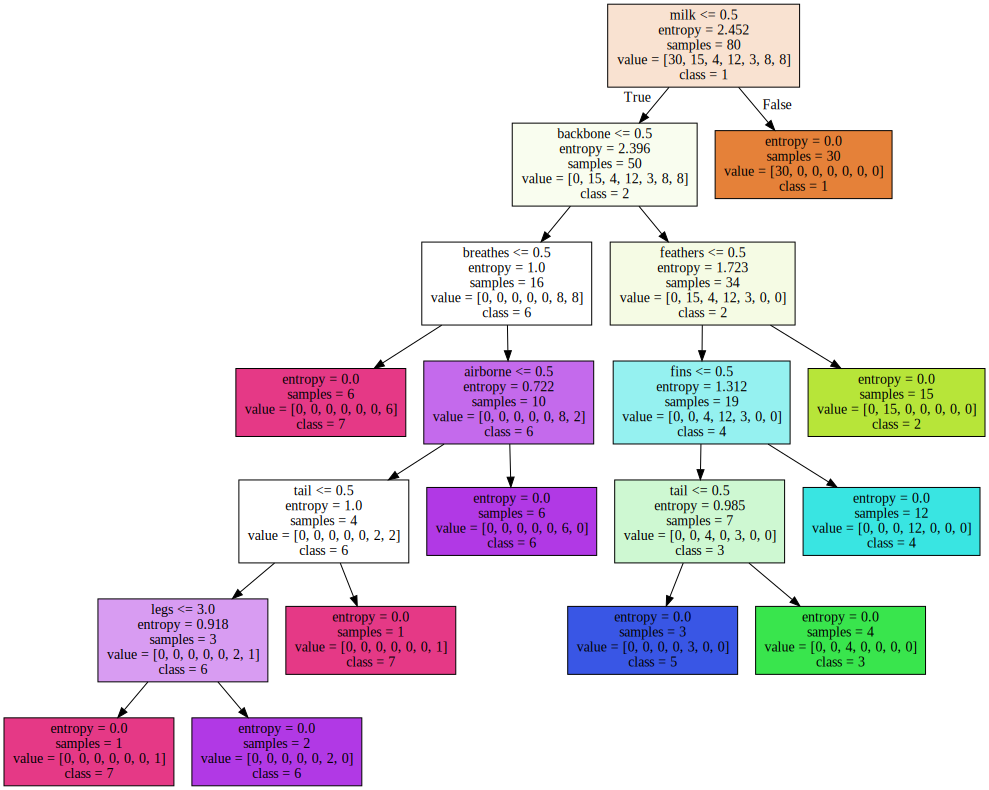

In [30]:
from sklearn.tree import export_graphviz
graphviz.Source(export_graphviz(clf,feature_names=X.columns,filled=True,
                                class_names=['1','2','3','4','5','6','7'],out_file=None))

In [11]:
!pip install graphviz